# Exploration of results from Bayesian modelling

We have run a hierarchical MCMC model to estimate galaxy pitch angle from clustered spiral arms obtained through the _Galaxy Builder_ citizen science project.

TODO: clean this up

In [9]:
import json
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import pymc3 as pm
from tqdm import tqdm
import scipy.stats as st
import corner
import warnings
from gzbuilder_analysis import load_fit_results

warnings.simplefilter('ignore', UserWarning)

In [10]:
fit_results = load_fit_results('../gzbuilder_results/output_files/tuning_results')

In [11]:
INPUT_FILE = 'n139d1000t500.pickle'

In [12]:
res = pd.read_pickle(INPUT_FILE)
bhsm = res['model']
trace = res['trace']

In [13]:
display(bhsm.model)

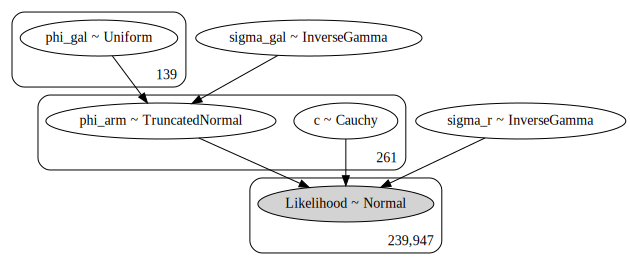

In [14]:
pm.model_to_graphviz(bhsm.model)

In [15]:
' '.join(trace.varnames)

'phi_gal_interval__ sigma_gal_log__ c sigma_r_log__ phi_arm_interval__ phi_gal sigma_gal sigma_r phi_arm'

In [16]:
gal_pa_samples = pd.DataFrame(
    trace['phi_gal'].T,
    index=bhsm.galaxies.index
)

In [17]:
print('N Galaxies:', len(res['model'].galaxies))
print('N Arms:    ', res['model'].n_arms)
print('N Points:  ', res['model'].data.shape[0])

N Galaxies: 139
N Arms:     261
N Points:   239947


In [18]:
pa_expectation = gal_pa_samples.mean(axis=1)
pa_std = gal_pa_samples.std(axis=1)

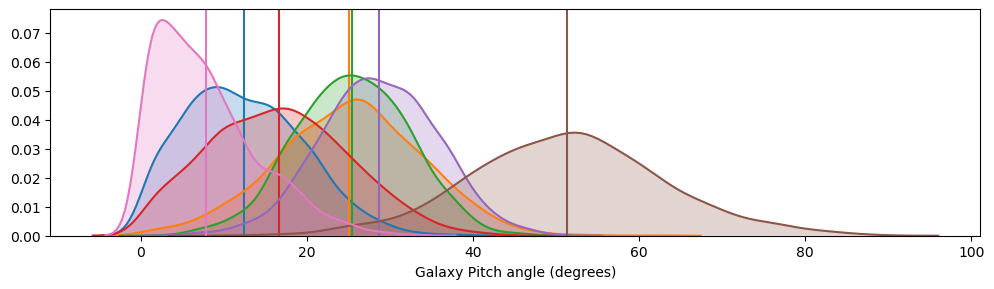

In [19]:
plt.figure(figsize=(12, 3), dpi=100)
sample = pa_expectation.sample(5)
for i, idx in enumerate(sample.index.values.tolist() + [pa_expectation.idxmax(), pa_expectation.idxmin()]):
    sns.kdeplot((gal_pa_samples.loc[idx]), shade=True, color=f'C{i}')
    plt.axvline(gal_pa_samples.loc[idx].mean(), color=f'C{i}')
# i = (gal_pa_samples.idxmax(), gal_pa_samples.idxmin())
plt.xlabel('Galaxy Pitch angle (degrees)')
plt.gca().get_legend().remove()
plt.savefig('plots/gal_pa_kde_sample.png', bbox_inches='tight')

What is the uncertainty on our estimate of arm pitch angles ($\sigma_{\phi_\mathrm{arm}})$? And on $\sigma_\mathrm{gal}$, the measure of inter-arm pitch angle variation?

In [20]:
from IPython.display import Latex

arm_uncertainty = trace.phi_arm.std(axis=0)

display(Latex(r'$\sigma_{{\phi_\mathrm{{arm}}}} = {:.2f} ± {:.2f}$'.format(arm_uncertainty.mean(), arm_uncertainty.std())))
display(Latex(r'$\sigma_\mathrm{{gal}} = {:.2f} ± {:.2f}$'.format(trace.sigma_gal.mean(), trace.sigma_gal.std())))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

What is our uncertainty on the galaxy's pitch angle relative to the number of arms identified?

n_arms,1,2,3,4
Err,9.86,7.90,6.77,5.95
Expected,11.02,7.79,6.36,5.51


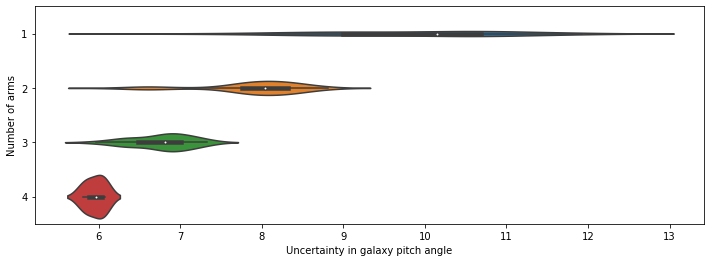

In [21]:
plt.figure(figsize=(12, 4))
sns.violinplot(pa_std, bhsm.galaxies.apply(len), orient='horizontal')
plt.xlabel('Uncertainty in galaxy pitch angle')
plt.ylabel('Number of arms')
plt.savefig('plots/error_vs_n_arms.png', bbox_inches='tight')

display(
    pd.concat((
        pa_std,
        bhsm.galaxies.apply(len)
    ), axis=1)
    .rename(columns={0: 'Err', 1: 'n_arms'})
    .groupby('n_arms')
    .mean()
    .assign(Expected=pd.Series([trace.sigma_gal.mean() / np.sqrt(i) for i in range(1, 5)], index=range(1, 5)))
    .T.round(2)
)

What does our model predict for inter-arm variance?

## Comparison to length-weighted pitch angles

Let's get some values for the length-weighted pitch angle of our galaxies:

In [22]:
# sample extraction
galaxies_df = pd.read_pickle('lib/merged_arms.pickle')
# keep only galaxies with one arm or more
galaxies_df = galaxies_df[galaxies_df.notna().any(axis=1)]
pa_lw_mean = galaxies_df.apply(
    lambda row: row['pipeline'].get_pitch_angle(row.drop('pipeline').dropna().values)[0],
    axis=1
).reindex_like(galaxies_df)

def get_err(row):
    return row.dropna()\
      .drop('pipeline')\
      .apply(lambda arm: arm.pa)\
      .std()
pa_lw_err = galaxies_df.apply(get_err, axis=1).reindex_like(galaxies_df).fillna(0)
print('Total number of galaxies:', len(pa_lw_err))

Total number of galaxies: 139


In [23]:
lw_df = pd.concat((
    pa_lw_mean.dropna().rename('lw'),
    pa_lw_err.rename('lw_err'),
    pa_expectation.rename('E'),
    pa_std.rename('E_err'),
    bhsm.galaxies.apply(len).rename('n'),
), axis=1).dropna()

# g = sns.pairplot(
#     lw_df.rename(columns=dict(
#         lw='Length-weighted',
#         lw_err='Length-weighted uncertainty',
#         E='Bayesian Expectation',
#         E_err='Bayesian uncertainty',
#     )),
#     hue='n', diag_kind='hist'
# )

# plt.figure(figsize=(8, 8))
# plt.errorbar(
#     lw_df['lw'], lw_df['E'],
#     xerr=lw_df['lw_err'], yerr=lw_df['E_err'],
#     fmt='o', alpha=0.4
# )
# plt.plot((0, 90), (0, 90), c='k', alpha=0.2)
# plt.xlim(0, 65)
# plt.ylim(0, 65)
# plt.xlabel('Length-weighted pitch angle')
# plt.ylabel('Expectation from Bayesian modelling')

The values are very consistent, as would be expected. However the measure of error generally used with length-weighted pitch angle measurement (sample error of arm segment pitch angle), does not provide as robust a measurement as the error in the posterior we obtain for $\phi_\mathrm{gal}$.

# Examination of arm pitch angle spread

In [24]:
n_arm_map = pd.Series(bhsm.gal_n_arms, index=bhsm.galaxies.index)

arm_pa_samples = pd.DataFrame(trace['phi_arm'].T, index=pd.MultiIndex.from_tuples([
    (i, j)
    for i in gal_pa_samples.index
    for j in range(n_arm_map.loc[i])
]))
arm_mean_pas = arm_pa_samples.mean(axis=1)

In [25]:
gal_mean_pas = gal_pa_samples.mean(axis=1).loc[arm_mean_pas.index.get_level_values(0)]
gal_mean_pas.index = arm_mean_pas.index

offset_samples = (arm_pa_samples - gal_pa_samples.loc[arm_mean_pas.index.get_level_values(0)].values)
offset_mean = offset_samples.mean(axis=1)
offset_std = offset_samples.std(axis=1)

n_arms = pd.Series(bhsm.gal_n_arms, index=bhsm.galaxies.index).loc[arm_mean_pas.index.get_level_values(0)]
n_arms.index = arm_mean_pas.index

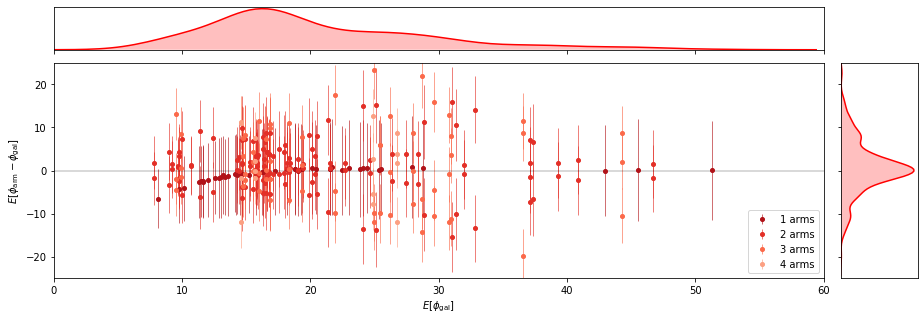

In [26]:
from matplotlib import cm

fig, ((pa_kd, null_ax), (scatter_ax, delta_kd)) = plt.subplots(2, 2, gridspec_kw={'width_ratios': [10, 1], 'height_ratios': [1, 5]}, figsize=(12, 5), sharex='col', sharey='row')

sns.kdeplot(gal_mean_pas, ax=pa_kd, shade=True, color='r')
pa_kd.set_yticks([])
null_ax.axis('off')
plt.sca(scatter_ax)

for i in np.unique(n_arms):
    plt.errorbar(
        gal_mean_pas[n_arms == i],
        offset_mean[n_arms == i],
    #     xerr=gal_std_pas,
        yerr=offset_std[n_arms == i],
        fmt='o',
        c=cm.Reds(1-i/6),
        ms=4,
        elinewidth=0.6,
        label=f'{i} arms',
    )
plt.gca().add_line(plt.Line2D((0, 90), (0, 0), c='k', alpha=0.2))
plt.xlim(0, 60)
d = 25
plt.ylim(-d, d)
plt.xlabel('$E[\phi_\mathrm{gal}]$')
plt.ylabel('$E[\phi_\mathrm{arm} - \phi_\mathrm{gal}]$');
plt.legend(loc='lower right')
plt.sca(delta_kd)
sns.kdeplot(offset_mean, ax=delta_kd, vertical=True, shade=True, color='r')
delta_kd.set_xticks([])
plt.subplots_adjust(hspace=0.1, wspace=0.04, left=0, right=1)
plt.savefig('plots/arm_pa_spread.pdf', bbox_inches='tight')
plt.savefig('plots/arm_pa_spread.png', bbox_inches='tight')

## Comparison to GZ2 and Hart (2017)

In [27]:
gz2_spiral_data = pd.read_csv('lib/gz2_spiral_data.csv', index_col=0)

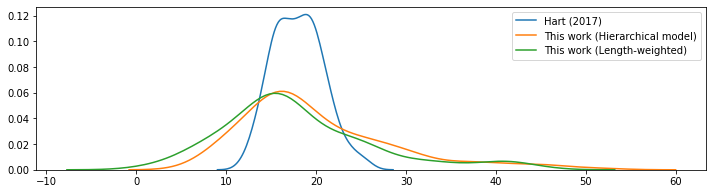

In [28]:
plt.figure(figsize=(12, 3))
sns.kdeplot(gz2_spiral_data['hart_pa'].dropna(), label='Hart (2017)')
sns.kdeplot(pa_expectation, label='This work (Hierarchical model)')
sns.kdeplot(pa_lw_mean.dropna(), label='This work (Length-weighted)')

In [29]:
def set_color_by_correlation(row, cmap=cm.get_cmap('RdYlGn', 12)):
    values = (np.array([cmap((value + 1) / 2) for value in row])  * [256, 256, 256, 1]).astype(int)
    return [f'background-color: rgba{tuple(value.tolist())}' for value in values]

,GZ2 Winding coefficient,Hart (2017),Expectation,Length-weighted
GZ2 Winding coefficient,1.000000,0.957395,0.423992,0.418452
Hart (2017),0.957395,1.000000,0.437370,0.451475
Expectation,0.423992,0.437370,1.000000,0.914848
Length-weighted,0.418452,0.451475,0.914848,1.000000


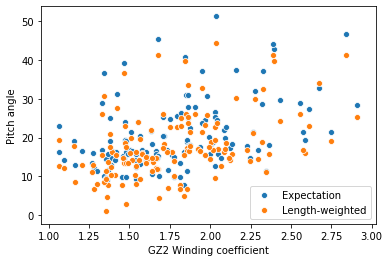

In [30]:
sns.scatterplot(gz2_spiral_data['winding'], pa_expectation, label='Expectation')
sns.scatterplot(gz2_spiral_data['winding'], pa_lw_mean, label='Length-weighted')
plt.xlabel('GZ2 Winding coefficient')
plt.ylabel('Pitch angle')
pd.concat((
    gz2_spiral_data['winding'].rename('GZ2 Winding coefficient'),
    gz2_spiral_data['hart_pa'].rename('Hart (2017)'),
    pa_expectation.rename('Expectation'),
    pa_lw_mean.rename('Length-weighted'),
), axis=1).corr().style.apply(set_color_by_correlation)

Text(0, 0.5, 'This work')

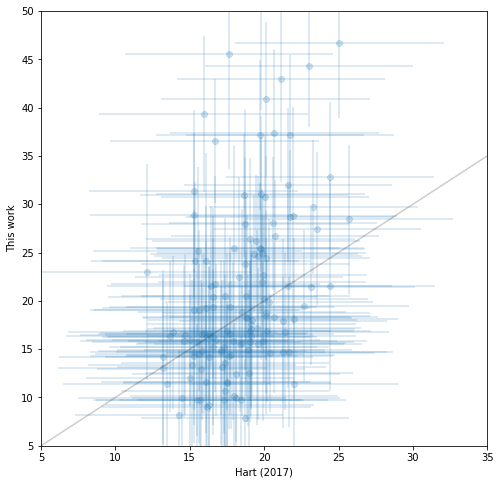

In [31]:
plt.figure(figsize=(8, 8))
df = pd.concat((gz2_spiral_data['hart_pa'], pa_expectation.rename('pa'), pa_std.rename('err')), axis=1).dropna()
plt.errorbar(df['hart_pa'], df['pa'], xerr=7, yerr=df['err'], fmt='o', alpha=0.2)
l = np.stack((plt.ylim(), plt.xlim()))
plt.plot((0, 90), (0, 90), c='k', alpha=0.2)
plt.xlim(5, 35)
plt.ylim(5, 50)
plt.xlabel('Hart (2017)')
plt.ylabel('This work')

## Potential source distributions

[Pringle & Dobbs (2019)](https://arxiv.org/pdf/1909.10291.pdf) propose that for a simple model of spiral awm winding, galaxy pitch angle should be uniform in $\cot\phi$ between some limits. We examine this possibility using repetitions of the [Kolmogorov-Smirnov](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) and [Anderson-Darling](https://en.wikipedia.org/wiki/Anderson%E2%80%93Darling_test) tests for different realizations of the posterior distribution of galaxy pitch angle (which we will refer to as _marginalized tests_). We also invsetigate the Beta distribution and Truncated Normal distribution as possible source distributions.

In [32]:
def cot(phi):
    return 1 / np.tan(np.radians(phi))

def acot(a):
    return np.degrees(np.arctan(1 / a))

def truncnorm(loc, scale, lower=0, upper=90):
    return st.truncnorm(
        (lower - loc) / scale, (upper - loc) / scale,
        loc=loc, scale=scale
    )

def truncnorm_nnlf(loc, scale, data, lower=0, upper=90):
    a, b = (lower - loc) / scale, (upper - loc) / scale
    return st.truncnorm.nnlf((a, b, loc, scale), data)

In [33]:
## Limits from Pringle and Dobbs
# LOWER_COT_BOUND = 1.0
# UPPER_COT_BOUND = 4.75

# lower_phi_bound = acot(UPPER_COT_BOUND)
# upper_phi_bound = acot(LOWER_COT_BOUND)
# print(f'{LOWER_COT_BOUND:.2f} < cot(ɸ) < {UPPER_COT_BOUND:.2f}')
# print(f'{lower_phi_bound:.2f} < ɸ < {upper_phi_bound:.2f}')

In [34]:
LOWER_COT_BOUND = cot(50)
UPPER_COT_BOUND = cot(15)

lower_phi_bound = acot(UPPER_COT_BOUND)
upper_phi_bound = acot(LOWER_COT_BOUND)
print(f'{LOWER_COT_BOUND:.2f} < cot(ɸ) < {UPPER_COT_BOUND:.2f}')
print(f'{lower_phi_bound:.2f} < ɸ < {upper_phi_bound:.2f}')

0.84 < cot(ɸ) < 3.73
15.00 < ɸ < 50.00


More sensitive limits:

In [35]:
LOWER_COT_BOUND2 = cot(50)
UPPER_COT_BOUND2 = cot(10)

lower_phi_bound2 = acot(UPPER_COT_BOUND2)
upper_phi_bound2 = acot(LOWER_COT_BOUND2)
print(f'{LOWER_COT_BOUND2:.2f} < cot(ɸ) < {UPPER_COT_BOUND2:.2f}')
print(f'{lower_phi_bound2:.2f} < ɸ < {upper_phi_bound2:.2f}')

0.84 < cot(ɸ) < 5.67
10.00 < ɸ < 50.00


Perform the _Marginalized_ tests for the different distributions

In [36]:
# Test against cot-uniform
ks = pd.Series([], name='ks_test_result', dtype=object)
anderson = pd.Series([], name='anderson_test_result', dtype=object)
cot_target_dist = st.uniform(LOWER_COT_BOUND, UPPER_COT_BOUND - LOWER_COT_BOUND)
comparison_dataset = cot_target_dist.rvs(10000)

# Test against cot-uniform with adjusted limits
ks2 = pd.Series([], name='ks_test_result2', dtype=object)
anderson2 = pd.Series([], name='anderson_test_result2', dtype=object)
cot_target_dist2 = st.uniform(LOWER_COT_BOUND2, UPPER_COT_BOUND2 - LOWER_COT_BOUND2)
comparison_dataset2 = cot_target_dist2.rvs(10000)


# Test against scaled beta
ks_beta = pd.Series([], name='ks_test_result', dtype=object)
anderson_beta = pd.Series([], name='anderson_test_result', dtype=object)
betas = []

# Test against truncated normal
ks_truncnorm = pd.Series([], name='ks_test_result', dtype=object)
anderson_truncnorm = pd.Series([], name='anderson_test_result', dtype=object)
truncnorms = []

with tqdm(range(trace['phi_gal'].shape[0])) as bar:
    for i in bar:
        phi_gal_est = trace['phi_gal'][i]
        cot_phi_gal_est = cot(phi_gal_est)
        
        cot_mask = (cot_phi_gal_est > LOWER_COT_BOUND) & (cot_phi_gal_est < UPPER_COT_BOUND)
        anderson[i] = st.anderson_ksamp((
            cot_phi_gal_est[cot_mask],
            comparison_dataset,
        ))
        ks[i] = st.kstest(
            cot_phi_gal_est[cot_mask],
            cot_target_dist.cdf,
        )
        
        cot_mask2 = (cot_phi_gal_est > LOWER_COT_BOUND2) & (cot_phi_gal_est < UPPER_COT_BOUND2)
        anderson2[i] = st.anderson_ksamp((
            cot_phi_gal_est[cot_mask2],
            comparison_dataset2,
        ))
        ks2[i] = st.kstest(
            cot_phi_gal_est[cot_mask2],
            cot_target_dist2.cdf,
        )
        
        beta_fit = st.beta(*st.beta.fit(phi_gal_est, fscale=90, floc=0))
        betas.append(beta_fit)
        truncnorm_fit = truncnorm(
            *minimize(lambda p: truncnorm_nnlf(*p, phi_gal_est), (10, 10))['x']
        )
        truncnorms.append(truncnorm_fit)

ks = ks.apply(pd.Series).rename(columns={0: 'value', 1: 'p'})
anderson = anderson.apply(pd.Series).rename(columns={0: 'value', 1: 'levels', 2: 'significance'})

ks2 = ks2.apply(pd.Series).rename(columns={0: 'value', 1: 'p'})
anderson2 = anderson2.apply(pd.Series).rename(columns={0: 'value', 1: 'levels', 2: 'significance'})

100%|██████████| 2000/2000 [02:49<00:00, 11.83it/s]


Cheeky helper function to do custom logarithmic histogramming:

In [37]:
def do_log_hist(vals, *args, **kwargs):
    cumulative = kwargs.pop('cumulative', False)
    counts, bins = np.histogram(np.log10(vals), bins='scott', *args, **kwargs)
    if cumulative:
        counts = np.cumsum(counts / counts.sum())
    line = plt.step(10**bins, np.concatenate(([0], counts)), color='C1')[0]
    plt.fill_between(10**np.repeat(bins, 2)[1:-1], np.repeat(counts, 2), color='C1', alpha=0.2)
    plt.xscale('log')

Thresholds:
       25%: 0.33, reject 66% of the time
       10%: 1.23, reject 38% of the time
        5%: 1.96, reject 21% of the time
      2.5%: 2.72, reject 11% of the time
        1%: 3.75, reject 5% of the time
      0.5%: 4.59, reject 2% of the time
      0.1%: 6.55, reject 0% of the time


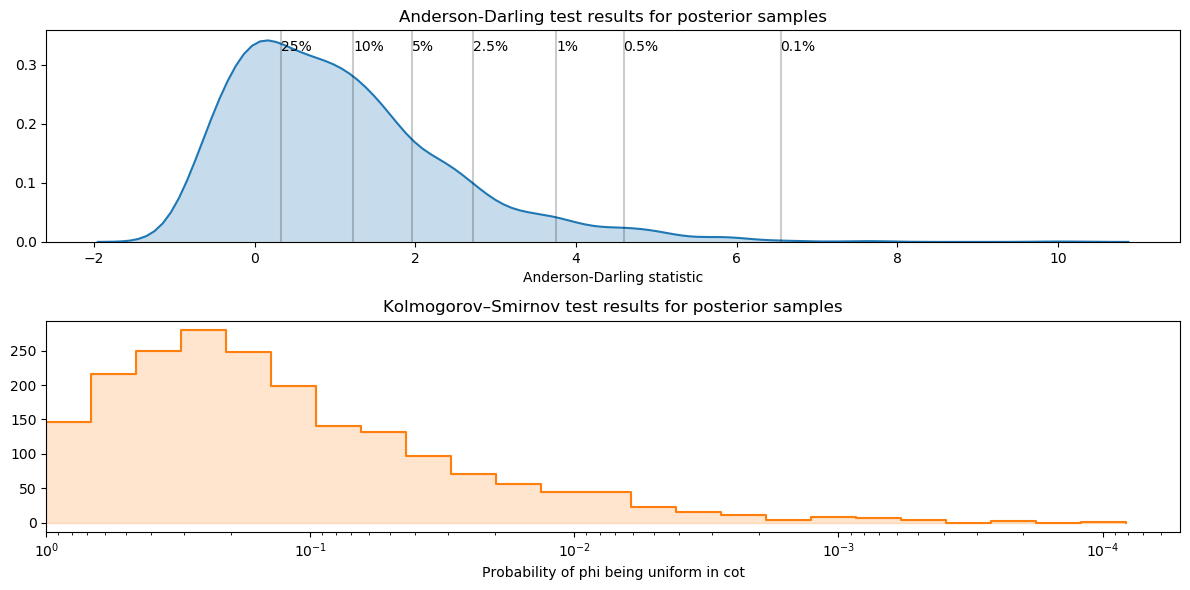

In [38]:
f, ax = plt.subplots(nrows=2, figsize=(12, 6), dpi=100)
plt.sca(ax[0])
plt.title('Anderson-Darling test results for posterior samples')
sns.kdeplot(anderson['value'], label='', shade=True)
print('Thresholds:')
for i, j in zip(
    ('25%', '10%', '5%', '2.5%', '1%', '0.5%', '0.1%'),
    np.stack(anderson['levels'].values).mean(axis=0)
):
    freq = (anderson['value'] >= j).sum() / len(anderson['value'])
    print(f'{i: >10}: {j:.2f}, reject {freq:.0%} of the time')
    plt.axvline(j, color='k', alpha=0.2)
    plt.text(j, plt.ylim()[1]*0.9, i)
plt.xlabel('Anderson-Darling statistic')
plt.sca(ax[1])
plt.title(r'Kolmogorov–Smirnov test results for posterior samples')
do_log_hist(ks['p'])
plt.xlim(left=1E0, right=plt.xlim()[0])
plt.xlabel(r'Probability of phi being uniform in cot')
plt.tight_layout()
plt.savefig('plots/cot_uniform_marginalized_tests.pdf', bbox_inches='tight')

Therefore we cannot unilaterally reject the hypothesis that the galaxy pitch angles for our sample are uniformly distributed in $\cot$ between the limits present in [Pringle & Dobbs (2019)](https://arxiv.org/pdf/1909.10291.pdf).

Adjusting the limits to be between 10° and 40° provides even stronger rejection of the null hypothesis

Thresholds (adjusted limits):
       25%: 0.33, reject 100% of the time
       10%: 1.23, reject 100% of the time
        5%: 1.96, reject 100% of the time
      2.5%: 2.72, reject 99% of the time
        1%: 3.75, reject 99% of the time
      0.5%: 4.59, reject 97% of the time
      0.1%: 6.55, reject 91% of the time


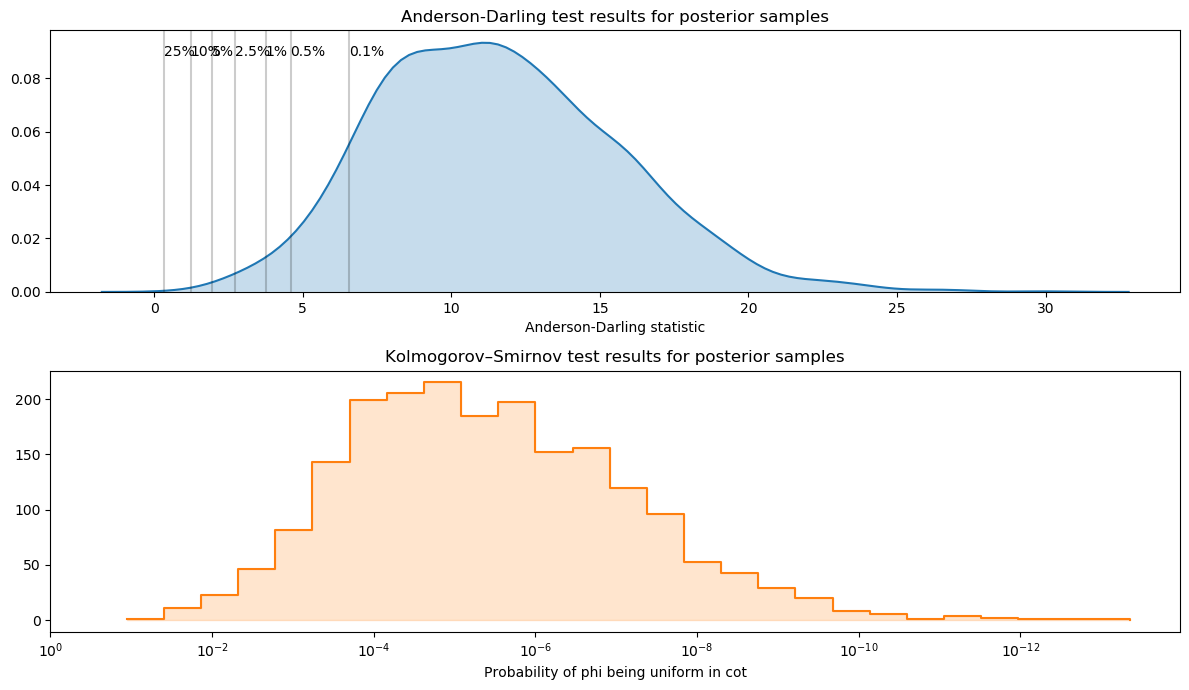

In [39]:
f, ax = plt.subplots(nrows=2, figsize=(12, 7), dpi=100)

plt.sca(ax[0])
plt.title('Anderson-Darling test results for posterior samples')
sns.kdeplot(anderson2['value'], label='', shade=True)
print('Thresholds (adjusted limits):')
for i, j in zip(
    ('25%', '10%', '5%', '2.5%', '1%', '0.5%', '0.1%'),
    np.stack(anderson2['levels'].values).mean(axis=0)
):
    freq = (anderson2['value'] >= j).sum() / len(anderson2['value'])
    print(f'{i: >10}: {j:.2f}, reject {freq:.0%} of the time')
    plt.axvline(j, color='k', alpha=0.2)
    plt.text(j, plt.ylim()[1]*0.9, i)
plt.xlabel('Anderson-Darling statistic')
plt.sca(ax[1])
plt.title(r'Kolmogorov–Smirnov test results for posterior samples')
do_log_hist(ks2['p'])
plt.xlim(left=1E0, right=plt.xlim()[0])
plt.xlabel(r'Probability of phi being uniform in cot')
plt.tight_layout()

Interestingly, the observed pitch angles could definitely be drawn from a Beta distribution like

$$\phi_\mathrm{gal} \sim 90 \times \mathrm{Beta}(a, b)$$

A normal distribution truncated between 0 and 90 is also a good candidate.

We illustrate the different potential source distributions using their fitted values for each draw (apart from the cot-uniform, which for convenience is a histogram of points sampled from the distribution)

In [40]:
_x = np.linspace(0, 90, 1000)
truncnorm_evals = np.array([t.pdf(_x) for t in truncnorms])
beta_evals = np.array([b.pdf(_x) for b in betas])

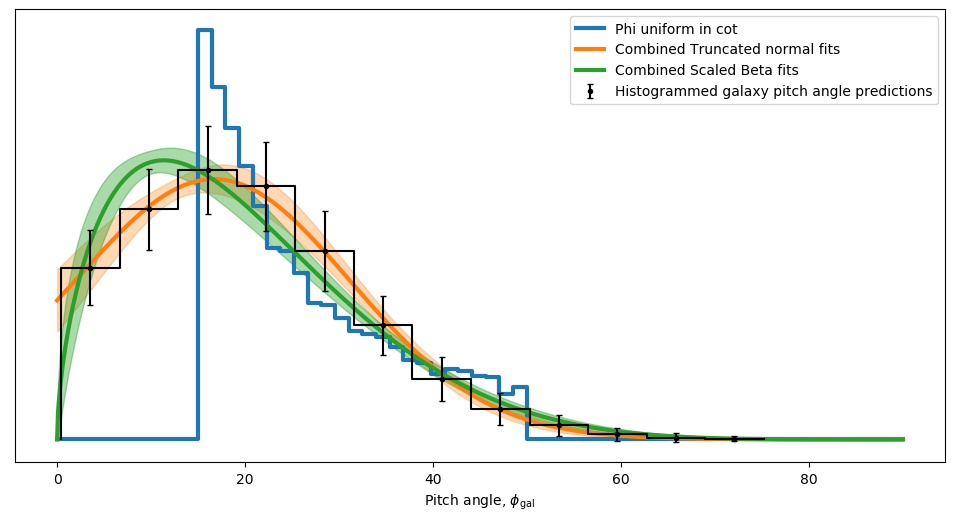

In [41]:
sf = len(gal_pa_samples.unstack().where(lambda a: (a > lower_phi_bound)&(a < upper_phi_bound)).dropna()) / gal_pa_samples.size

_x = np.linspace(0, 90, 1000)
plt.figure(figsize=(12, 6), dpi=100)
cot_counts, cot_bins = np.histogram(acot(comparison_dataset), density=True, bins='scott')
ct_l = plt.step(
    np.concatenate(([0], cot_bins, [90])),
    np.concatenate(([0, 0], cot_counts, [0])) * sf,
    color='C0', label='Phi uniform in cot', lw=3
)
tn_mns = truncnorm_evals.mean(axis=0)
tn_stds = truncnorm_evals.std(axis=0)
tn_l = plt.plot(_x, tn_mns, c='C1', lw=3, label='Combined Truncated normal fits')
plt.fill_between(
    _x,
    tn_mns - tn_stds,
    tn_mns + tn_stds,
    color='C1', alpha=0.3
)
bt_l = plt.plot(_x, beta_evals.mean(axis=0), c='C2', lw=3, label='Combined Scaled Beta fits')
bt_mns = beta_evals.mean(axis=0)
bt_stds = beta_evals.std(axis=0)
plt.fill_between(
    _x,
    bt_mns - bt_stds,
    bt_mns + bt_stds,
    color='C2', alpha=0.4
)

# plot a histogram with errors of the posterior realizations used to fit things
counts, bins = np.histogram(gal_pa_samples.T.iloc[0], bins='auto', density=True)

res = pd.DataFrame([], columns=np.concatenate((bins[:-1] + np.diff(bins) / 2, (90,))), index=gal_pa_samples.index)
for idx, val in gal_pa_samples.iteritems():
    counts, _ = np.histogram(val, bins=bins, density=True)
    res.loc[idx] = pd.Series(counts, index=bins[:-1] + np.diff(bins) / 2)

l_data = plt.errorbar(
    res.columns, res.mean(), yerr=res.std(),
    fmt='.', color='k',
    label='Histogrammed galaxy pitch angle predictions',
    zorder=3, capsize=2
)

plt.plot(np.concatenate((np.repeat(bins, 2), (90,))), np.concatenate(([0], np.repeat(res.mean(), 2).values)), c='k')
plt.legend()
plt.xlabel(r'Pitch angle, $\phi_\mathrm{gal}$')
plt.yticks([]);
plt.savefig('plots/distribution_comparison.pdf', bbox_inches='tight')

## What about on an arm-by-arm basis?

In [42]:
LOWER_COT_BOUND_ARM = LOWER_COT_BOUND  # = cot(50)
UPPER_COT_BOUND_ARM = UPPER_COT_BOUND  # = cot(15)

lower_phi_bound_arm = acot(UPPER_COT_BOUND_ARM)
upper_phi_bound_arm = acot(LOWER_COT_BOUND_ARM)
print(f'{LOWER_COT_BOUND_ARM:.2f} < cot(ɸ) < {UPPER_COT_BOUND_ARM:.2f}')
print(f'{lower_phi_bound_arm:.2f} < ɸ < {upper_phi_bound_arm:.2f}')

0.84 < cot(ɸ) < 3.73
15.00 < ɸ < 50.00


In [43]:
# Test against cot-uniform
ks_arm = pd.Series([], name='ks_test_result', dtype=object)
anderson_arm = pd.Series([], name='anderson_test_result', dtype=object)
arm_cot_target_dist = st.uniform(LOWER_COT_BOUND_ARM, UPPER_COT_BOUND_ARM - LOWER_COT_BOUND_ARM)
arm_comparison_dataset = arm_cot_target_dist.rvs(10000)

with tqdm(range(trace['phi_arm'].shape[0])) as bar:
    for i in bar:
        phi_arm_est = trace['phi_arm'][i]
        cot_phi_arm_est = cot(phi_arm_est)
        cot_mask = (cot_phi_arm_est > LOWER_COT_BOUND_ARM) & (cot_phi_arm_est < UPPER_COT_BOUND_ARM)
        anderson_arm[i] = st.anderson_ksamp((
            cot_phi_arm_est[cot_mask],
            arm_comparison_dataset,
        ))
        ks_arm[i] = st.kstest(
            cot_phi_arm_est[cot_mask],
            arm_cot_target_dist.cdf,
        )

ks_arm = ks_arm.apply(pd.Series).rename(columns={0: 'value', 1: 'p'})
anderson_arm = anderson_arm.apply(pd.Series).rename(columns={0: 'value', 1: 'levels', 2: 'significance'})

100%|██████████| 2000/2000 [00:18<00:00, 105.76it/s]


In [44]:
rejection_frac = pd.Series([
    (anderson_arm['value'] >= j).sum() / len(anderson['value'])
    for j in np.stack(anderson_arm['levels'].values).mean(axis=0)
], index=('25%', '10%', '5%', '2.5%', '1%', '0.5%', '0.1%'))

Thresholds:
       25%: 0.33, reject 100% of the time
       10%: 1.23, reject 50% of the time
        5%: 1.96, reject 2% of the time
      2.5%: 2.72, reject 0% of the time
        1%: 3.75, reject 0% of the time
      0.5%: 4.59, reject 0% of the time
      0.1%: 6.55, reject 0% of the time


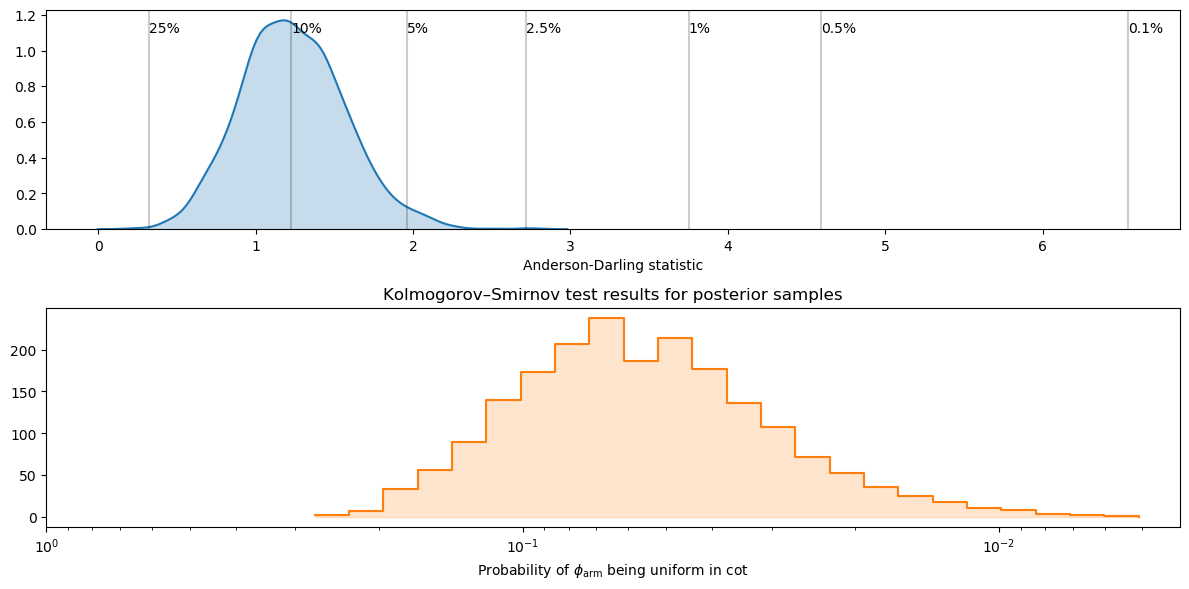

In [45]:
f, ax = plt.subplots(nrows=2, figsize=(12, 6), dpi=100)
plt.sca(ax[0])
sns.kdeplot(anderson_arm['value'], label='', shade=True)
print('Thresholds:')
for i, j in zip(
    ('25%', '10%', '5%', '2.5%', '1%', '0.5%', '0.1%'),
    np.stack(anderson_arm['levels'].values).mean(axis=0)
):
    print(f'{i: >10}: {j:.2f}, reject {rejection_frac.loc[i]:.0%} of the time')
    plt.axvline(j, color='k', alpha=0.2)
    plt.text(j, plt.ylim()[1]*0.9, i)
plt.xlabel('Anderson-Darling statistic')
plt.sca(ax[1])
plt.title(r'Kolmogorov–Smirnov test results for posterior samples')
do_log_hist(ks_arm['p'])
plt.xlim(left=1E0, right=plt.xlim()[0])
plt.xlabel(r'Probability of $\phi_\mathrm{arm}$ being uniform in cot')
plt.tight_layout()
plt.savefig('plots/arm_cot_uniform_marginalized_tests.pdf', bbox_inches='tight')
plt.savefig('plots/arm_cot_uniform_marginalized_tests.jpg', bbox_inches='tight')

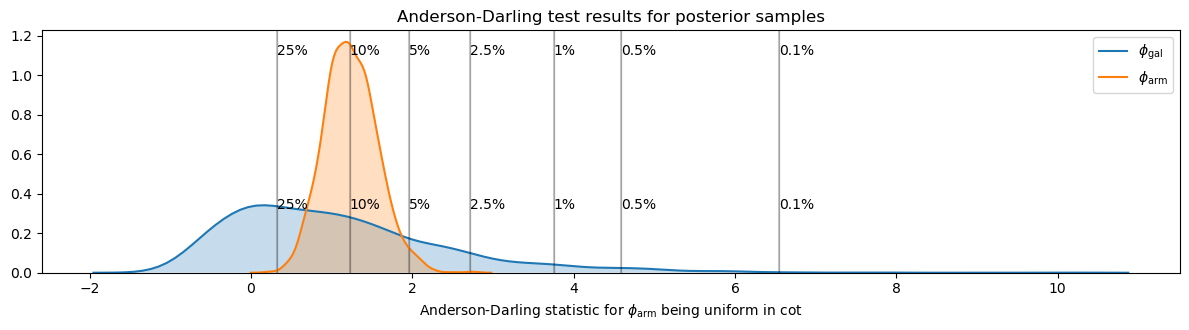

In [46]:
f, ax = plt.subplots(nrows=1, figsize=(12, 3.4), sharex=True, dpi=100)
plt.title('Anderson-Darling test results for posterior samples')
sns.kdeplot(anderson['value'], label=r'$\phi_\mathrm{gal}$', shade=True)
for i, j in zip(
    ('25%', '10%', '5%', '2.5%', '1%', '0.5%', '0.1%'),
    np.stack(anderson['levels'].values).mean(axis=0)
):
    plt.axvline(j, color='k', alpha=0.2)
    plt.text(j, plt.ylim()[1]*0.9, i)
plt.xlabel('Anderson-Darling statistic for $\phi_\mathrm{gal}$ being uniform in cot')
sns.kdeplot(anderson_arm['value'], c='C1', label=r'$\phi_\mathrm{arm}$', shade=True)
for i, j in zip(
    ('25%', '10%', '5%', '2.5%', '1%', '0.5%', '0.1%'),
    np.stack(anderson_arm['levels'].values).mean(axis=0)
):
    plt.axvline(j, color='k', alpha=0.2, lw=2 if j == '1%' else 1)
    plt.text(j, plt.ylim()[1]*0.9, i)
plt.xlabel('Anderson-Darling statistic for $\phi_\mathrm{arm}$ being uniform in cot')
# [a.set_yticks([]) for a in ax];
plt.tight_layout()
plt.savefig('plots/combined_cot_uniform_marginalized_tests.pdf', bbox_inches='tight')
plt.savefig('plots/combined_cot_uniform_marginalized_tests.jpg', bbox_inches='tight')

Scale the histogram such that the histograms match (densities within bounds add up to one)

In [47]:
sf = len(arm_pa_samples.T.where(lambda a: (a > lower_phi_bound_arm)&(a < upper_phi_bound_arm)).unstack().dropna()) / arm_pa_samples.size

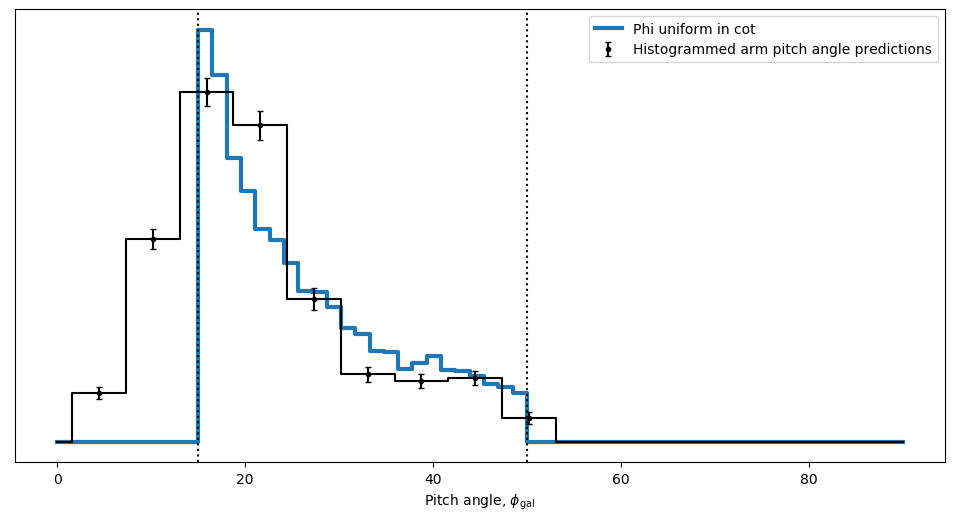

In [48]:
_x = np.linspace(0, 90, 1000)
plt.figure(figsize=(12, 6), dpi=100)
cot_counts, cot_bins = np.histogram(
    acot(arm_comparison_dataset),
    density=True,
    bins='scott',
    range=(lower_phi_bound_arm, upper_phi_bound_arm)
)
ct_l = plt.step(
    np.concatenate(([0], cot_bins, [90])),
    np.concatenate(([0, 0], cot_counts, [0])),
    color='C0', label='Phi uniform in cot', lw=3
)
# plot a histogram with errors of the posterior realizations used to fit things
# counts, bins = np.histogram(arm_pa_samples.T.iloc[0], bins='auto', density=True)

counts, bins = np.histogram(
    arm_pa_samples.T.iloc[0],
    bins='scott', density=True
)
res = pd.DataFrame([], columns=np.concatenate((bins[:-1] + np.diff(bins) / 2, (90,))), index=arm_pa_samples.index)
for idx, val in arm_pa_samples.iteritems():
    counts, _ = np.histogram(val, bins=bins, density=True)
    res.loc[idx] = pd.Series(counts, index=bins[:-1] + np.diff(bins) / 2)

l_data = plt.errorbar(
    res.columns,
    res.replace(0, np.nan).mean() / sf,
    yerr=res.replace(0, np.nan).std() / sf,
    fmt='.', color='k',
    label='Histogrammed arm pitch angle predictions',
    zorder=3, capsize=2
)
plt.step(
    np.concatenate(([0], bins, [90])),
    np.concatenate(([0], res.mean().fillna(0), [0])) / sf,
    where='post', c='k'
)
plt.axvline(lower_phi_bound_arm, c='k', ls=':')
plt.axvline(upper_phi_bound_arm, c='k', ls=':')
plt.legend()
plt.xlabel(r'Pitch angle, $\phi_\mathrm{gal}$')
plt.yticks([]);
plt.savefig('plots/arm_distribution_comparison.pdf', bbox_inches='tight')
plt.savefig('plots/arm_distribution_comparison.jpg', bbox_inches='tight')

## Morphology comparison

Does pitch angle vary with bulge or bar strength?

In [49]:
from astropy.io import fits
meta = pd.read_csv('lib/gal-metadata.csv', index_col=0)
gz_table = fits.open('../source_files/NSA_GalaxyZoo.fits')
gz_k = {k: gz_table[1].data[k] for k in gz_table[1].data.dtype.names}
gz_df = pd.DataFrame({k: v for k, v in gz_k.items() if type(v[0]) != np.ndarray}, dtype=object).set_index('dr7objid')

In [50]:
subject_metadata = (
    pd.read_csv('lib/galaxy-builder-subjects.csv', index_col=0)
    .metadata
    .apply(lambda s: pd.Series(json.loads(s)))
)

gz2_data = (
    subject_metadata[['SDSS dr7 id']]
        .drop_duplicates()
        .reindex(bhsm.galaxies.index)
        .reset_index()
        .rename(columns=dict(index='subject_id'))
        .dropna() # remove galaxies without SDSS DS7 IDs (early test galaxies)
        .astype('int64')
        # do the merge (could just use join)
        .merge(gz_df, how='right', left_on='SDSS dr7 id', right_index=True)
        .dropna() # get rid of galaxies which didn't match
        .set_index('subject_id')
)

In [51]:
BULGE_SPLIT_POINT = 0.28

morphology_comparison = pd.concat((
    gz2_data.t03_bar_a06_bar_fraction.rename('bar_fraction').astype(float),
    gz2_data.t05_bulge_prominence_a10_no_bulge_fraction.rename('no_bulge_fraction').astype(float),
    gz2_data.t05_bulge_prominence_a11_just_noticeable_fraction.rename('just_noticeable_bulge_fraction').astype(float),
    gz2_data.t05_bulge_prominence_a12_obvious_fraction.rename('obvious_bulge_fraction').astype(float),
    gz2_data.t05_bulge_prominence_a13_dominant_fraction.rename('dominant_bulge_fraction').astype(float),
    pa_expectation.rename('phi'),
    fit_results.bulge_frac,
    fit_results.bar_frac,
    pa_std.rename('sd'),
    bhsm.galaxies.apply(len).rename('n'),
), axis=1).dropna()

# derived quantities
morphology_comparison.eval('no_bar = bar_fraction < 0.2', inplace=True)
morphology_comparison.eval('strongly_barred = bar_fraction > 0.5', inplace=True)
morphology_comparison.eval(
    'bulge_strength = \
        0.2 * just_noticeable_bulge_fraction \
        + 0.8 * obvious_bulge_fraction \
        + 1.0 * dominant_bulge_fraction\
    ',
    inplace=True
)
morphology_comparison.eval('bulge_dominated = bulge_strength > @BULGE_SPLIT_POINT', inplace=True)
morphology_comparison.eval('central_frac = bulge_frac + bar_frac', inplace=True)

0.09280000180006029 0.7538000136613846


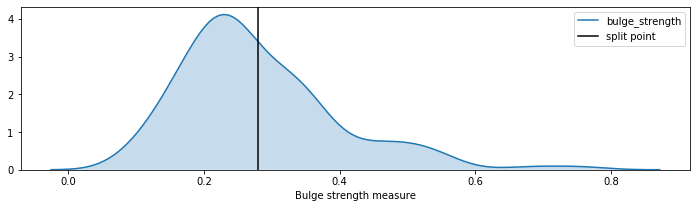

In [52]:
plt.figure(figsize=(12, 3))
sns.kdeplot(morphology_comparison.bulge_strength, shade=True)
plt.axvline(BULGE_SPLIT_POINT, c='k', label='split point')
plt.xlabel('Bulge strength measure')
plt.legend();
print(morphology_comparison.bulge_strength.min(), morphology_comparison.bulge_strength.max())

In [53]:
print('Percent bulge dominated = {:.0%}'.format(
    morphology_comparison.bulge_dominated.sum() / len(morphology_comparison.bulge_dominated)
))
print('Percent strongly barred = {:.0%}'.format(
    morphology_comparison.strongly_barred.sum() / len(morphology_comparison.strongly_barred)
))
print('Percent without bar = {:.0%}'.format(
    morphology_comparison.no_bar.sum() / len(morphology_comparison.no_bar)
))

Percent bulge dominated = 39%
Percent strongly barred = 26%
Percent without bar = 39%


In [54]:
n_bulge_dominated = morphology_comparison.bulge_dominated.sum()
n_disc_dominated = (~morphology_comparison.bulge_dominated).sum()
n_strong_bar = morphology_comparison.strongly_barred.sum()
n_no_bar = morphology_comparison.no_bar.sum()

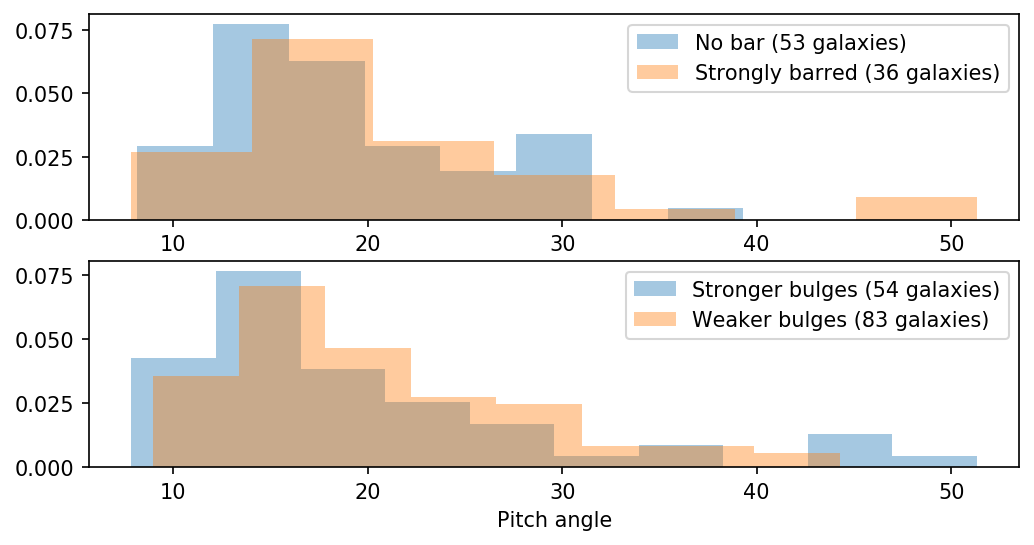

In [55]:
plt.figure(figsize=(8, 4), dpi=150)
plt.subplot(211)
sns.distplot(
    morphology_comparison['phi'][morphology_comparison['no_bar']].rename('No bar'),
    label=f'No bar ({n_no_bar} galaxies)',
    kde=False, norm_hist=True,
)
sns.distplot(
    morphology_comparison['phi'][morphology_comparison['strongly_barred']].rename('Bar'),
    label=f'Strongly barred ({n_strong_bar} galaxies)',
    kde=False, norm_hist=True,
)
plt.xlabel('Pitch angle')
plt.legend()

plt.subplot(212)
sns.distplot(
    morphology_comparison['phi'][
        morphology_comparison['bulge_dominated']
    ],
    label=f'Stronger bulges ({n_bulge_dominated} galaxies)',
    kde=False, norm_hist=True,
)
sns.distplot(
    morphology_comparison['phi'][
        np.logical_not(morphology_comparison['bulge_dominated'])
    ],
    label=f'Weaker bulges ({n_disc_dominated} galaxies)',
    kde=False, norm_hist=True,
)
plt.xlabel('Pitch angle')
plt.legend()

The correlation matrix below shows very weak links between morphology and pitch angle, as does the density plot from the trace

In [56]:
subset = morphology_comparison.drop(
    columns=['no_bar', 'strongly_barred', 'bulge_dominated']
)
corr_df = pd.concat((
    subset.corr(method='pearson').loc[['phi', 'sd', 'n']].T.add_suffix('_pearson'),
    subset.corr(method='spearman').loc[['phi', 'sd', 'n']].T.add_suffix('_spearman'),
    subset.corr(method='kendall').loc[['phi', 'sd', 'n']].T.add_suffix('_kendall'),
), axis=1).sort_index(axis=1)
corr_df.columns = pd.MultiIndex.from_tuples([c.split('_') for c in corr_df.columns])
corr_df.style.apply(set_color_by_correlation)

We can see a similar lack of correlation using density plots (which encompasses the whole trace rather than just the expectation)

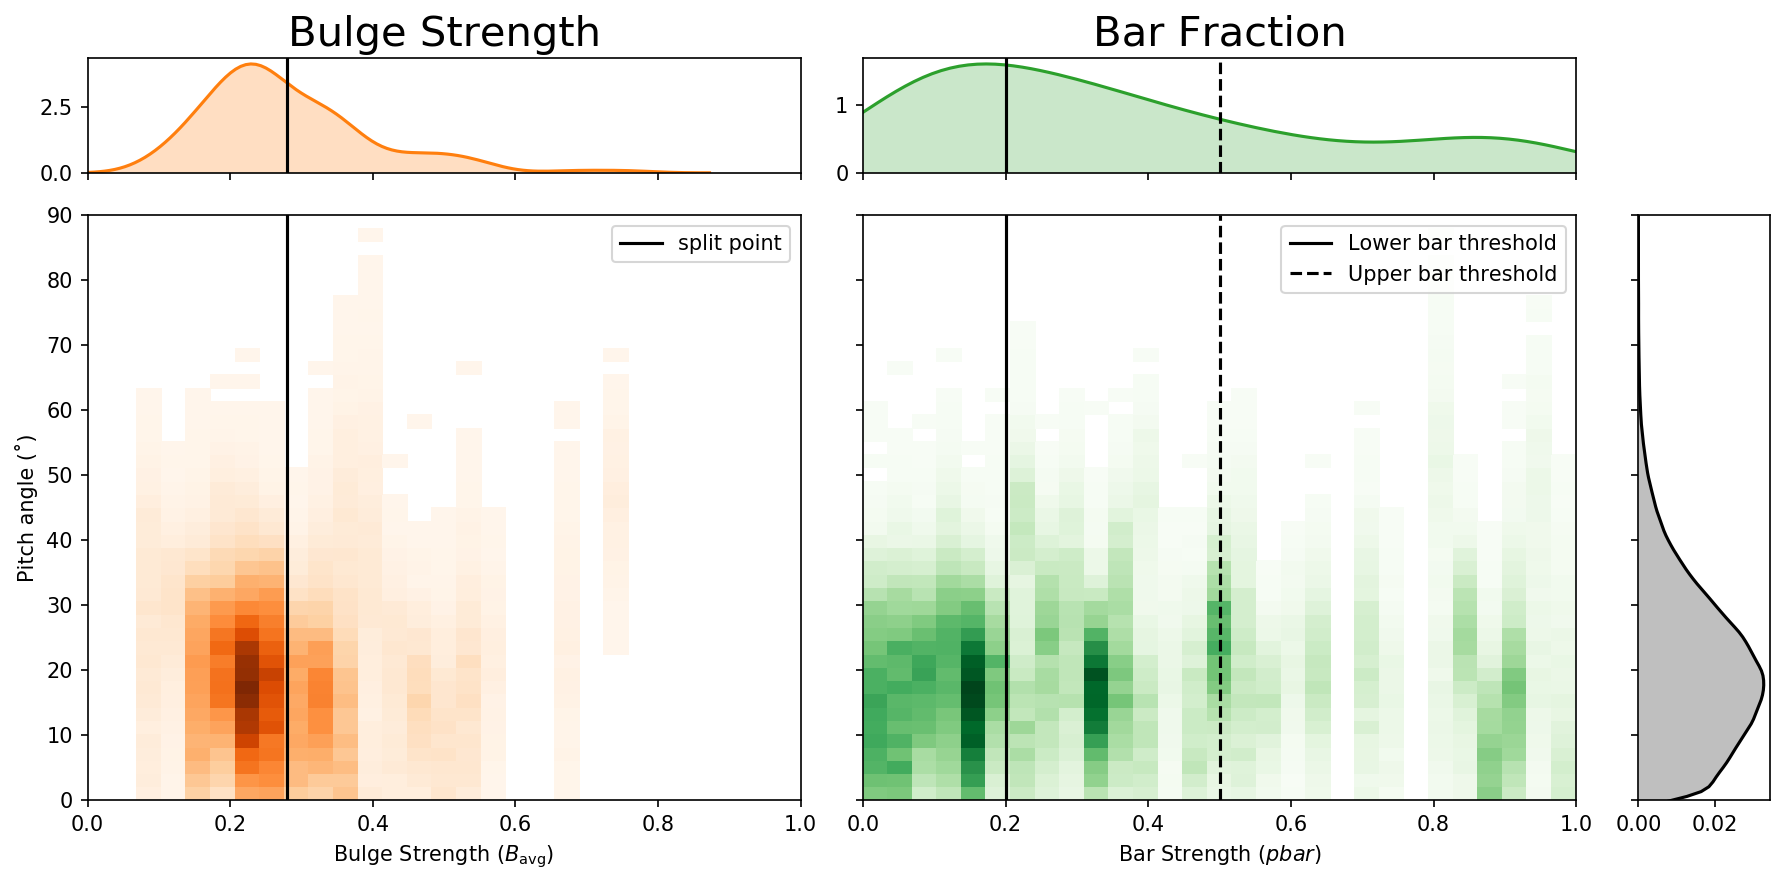

In [57]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.text import Annotation
from matplotlib import rc
rc('text', usetex=False)

pa_samples = gal_pa_samples.T.sample(500).unstack()

reindex_bulge_fractions = morphology_comparison['bulge_strength'].reindex(pa_samples.index.get_level_values(0))
reindex_bulge_fractions.index = pa_samples.index

reindex_bar_fractions = morphology_comparison['bar_fraction'].reindex(pa_samples.index.get_level_values(0))
reindex_bar_fractions.index = pa_samples.index

sampled_df = pd.concat((
    pa_samples.rename('phi'),
    reindex_bar_fractions,
    reindex_bulge_fractions,
), axis=1)


fig = plt.figure(figsize=(10*1.2, 5*1.2), dpi=150)
gs = GridSpec(5, 9, figure=fig)
ax_bg_hx = fig.add_subplot(gs[1:5, 0:4])
ax_bg_kd = fig.add_subplot(gs[0, 0:4], sharex=ax_bg_hx)
ax_br_hx = fig.add_subplot(gs[1:5, 4:8], sharex=ax_bg_hx, sharey=ax_bg_hx)
ax_br_kd = fig.add_subplot(gs[0:1, 4:8], sharex=ax_br_hx)
ax_pa_kd = fig.add_subplot(gs[1:5, 8:9], sharey=ax_bg_hx)

bx = np.linspace(0, 1, 30)
by = np.linspace(0, 90, 45)
ax_bg_hx.hist2d(*sampled_df[['bulge_strength', 'phi']].dropna().values.T, cmap='Oranges', cmin=0.001, bins=(bx, by))
ax_bg_hx.set_xlim(0, 1)
sns.kdeplot(morphology_comparison['bulge_strength'], ax=ax_bg_kd, c='C1', label='', shade=True, clip=(0, 1), bw='scott')

ax_br_hx.hist2d(*sampled_df[['bar_fraction', 'phi']].dropna().values.T, cmap='Greens', cmin=0.001, bins=(bx, by))
sns.kdeplot(morphology_comparison['bar_fraction'], ax=ax_br_kd, c='C2', label='', shade=True, clip=(0, 1), bw='scott')

sns.kdeplot(gal_pa_samples.unstack(), ax=ax_pa_kd, c='k', shade=True, vertical=True, clip=(0, 90), bw='scott')

plt.sca(ax_bg_hx)
plt.axvline(BULGE_SPLIT_POINT, c='k', label='split point')
plt.legend()
plt.sca(ax_bg_kd)
plt.axvline(BULGE_SPLIT_POINT, c='k', label='split point')
plt.sca(ax_br_hx)
plt.axvline(0.2, c='k', label='Lower bar threshold')
plt.axvline(0.5, c='k', ls='--', label='Upper bar threshold')
plt.legend()
plt.sca(ax_br_kd)
plt.axvline(0.2, c='k', label='Lower bar threshold')
plt.axvline(0.5, c='k', ls='--', label='Upper bar threshold')

plt.setp([
    ax_br_hx.get_yticklabels(),
    ax_pa_kd.get_yticklabels(),
    ax_bg_kd.get_xticklabels(),
    ax_br_kd.get_xticklabels(),
], visible=False)

ax_bg_hx.set_xlabel(r'Bulge Strength ($B_\mathrm{avg}$)')
ax_bg_hx.set_ylabel('Pitch angle (˚)')
ax_br_hx.set_xlabel(r'Bar Strength ($\it{pbar}$)')
ax_bg_kd.set_title('Bulge Strength', dict(fontsize=20))
ax_br_kd.set_title('Bar Fraction', dict(fontsize=20))
plt.tight_layout()
plt.savefig('plots/bulge_bar_phigal_distribution.jpg', bbox_inches='tight')
plt.savefig('plots/bulge_bar_phigal_distribution.pdf', bbox_inches='tight')
del reindex_bulge_fractions
del reindex_bar_fractions
del sampled_df

We'll do more marginalized Anderson-Darling tests to determine if the pitch angles of galaxies with our morphological selections are drawn from different distributions (null hypothesis being that they are drawn from the same distribution).

We'll also test for a difference with respect to arms:

In [58]:
arm_morphology_comparison = morphology_comparison.reindex(bhsm.galaxies.index[bhsm.gal_arm_map])
arm_morphology_comparison.index = pd.MultiIndex.from_tuples([
    (bhsm.galaxies.index[i], arm_idx)
    for i in range(len(bhsm.galaxies.index))
    for arm_idx in range(bhsm.gal_n_arms[i])
], names=('subject_id', 'arm_index'))

arm_morphology_comparison.dropna(inplace=True)

arm_pa_samples_ = arm_pa_samples.reindex(arm_morphology_comparison.index)

In [59]:
arm_subset = arm_morphology_comparison.drop(columns=['no_bar', 'strongly_barred', 'bulge_dominated'])\
    .assign(phi_arm=arm_pa_samples_.mean(axis=1), phi_arm_sd=arm_pa_samples_.std(axis=1))
arm_corr_df = pd.concat((
    arm_subset.corr(method='pearson').loc[['phi_arm', 'phi_arm_sd']].T.add_suffix('-pearson'),
    arm_subset.corr(method='spearman').loc[['phi_arm', 'phi_arm_sd']].T.add_suffix('-spearman'),
    arm_subset.corr(method='kendall').loc[['phi_arm', 'phi_arm_sd']].T.add_suffix('-kendall'),
), axis=1).sort_index(axis=1)
arm_corr_df.columns = pd.MultiIndex.from_tuples([c.split('-') for c in arm_corr_df.columns])
arm_corr_df.style.apply(set_color_by_correlation)

In [60]:
arm_morphology_comparison['no_bar']

subject_id  arm_index
20902077    0            False
            1            False
20902054    0            False
            1            False
20902008    0            False
                         ...  
21096798    0             True
            1             True
21096940    0            False
            1            False
21096833    0             True
Name: no_bar, Length: 257, dtype: object

In [61]:
# Test against cot-uniform
anderson_bulge = pd.Series([], name='anderson_test_result', dtype=object)
anderson_bar = pd.Series([], name='anderson_test_result', dtype=object)

with tqdm(gal_pa_samples.reindex(morphology_comparison.index).T.iterrows(), total=gal_pa_samples.shape[1]) as bar:
    for i, phi_gal_est in bar:
        anderson_bar[i] = st.anderson_ksamp((
            phi_gal_est[morphology_comparison['no_bar']].rename('No bar'),
            phi_gal_est[~(
                morphology_comparison['no_bar'].astype(bool)
                | morphology_comparison['strongly_barred'].astype(bool)
            )],
            phi_gal_est[morphology_comparison['strongly_barred']].rename('Bar'),
        ))
        anderson_bulge[i] = st.anderson_ksamp((
            phi_gal_est[morphology_comparison['bulge_dominated']],
            phi_gal_est[~morphology_comparison['bulge_dominated']]
        ))

anderson_bulge = anderson_bulge.apply(pd.Series).rename(columns={0: 'value', 1: 'levels', 2: 'significance'})
anderson_bar = anderson_bar.apply(pd.Series).rename(columns={0: 'value', 1: 'levels', 2: 'significance'})

# Test against cot-uniform
arm_anderson_bulge = pd.Series([], name='anderson_test_result', dtype=object)
arm_anderson_bar = pd.Series([], name='anderson_test_result', dtype=object)

with tqdm(arm_pa_samples_.T.iterrows(), total=arm_pa_samples_.shape[1]) as bar:
    for i, phi_arm_est in bar:
        arm_anderson_bar[i] = st.anderson_ksamp((
            # no bar
            phi_arm_est[arm_morphology_comparison['no_bar']],
            # weak bar
            phi_arm_est[~(
                arm_morphology_comparison['no_bar'].astype(bool)
                | arm_morphology_comparison['strongly_barred'].astype(bool)
            )],
            # strong bar
            phi_arm_est[arm_morphology_comparison['strongly_barred']],
        ))
        arm_anderson_bulge[i] = st.anderson_ksamp((
            phi_arm_est[arm_morphology_comparison['bulge_dominated']],
            phi_arm_est[~arm_morphology_comparison['bulge_dominated'].astype(bool)]
        ))

arm_anderson_bulge = arm_anderson_bulge.apply(pd.Series).rename(columns={0: 'value', 1: 'levels', 2: 'significance'})
arm_anderson_bar = arm_anderson_bar.apply(pd.Series).rename(columns={0: 'value', 1: 'levels', 2: 'significance'})

100%|██████████| 2000/2000 [00:23<00:00, 85.78it/s] 


Bulge strength Thresholds:
       25%: 0.33, reject 28% (100%) of the time
       10%: 1.23, reject 11% (70%) of the time
        5%: 1.96, reject 5% (1%) of the time
      2.5%: 2.72, reject 2% (0%) of the time
        1%: 3.75, reject 1% (0%) of the time
      0.5%: 4.59, reject 0% (0%) of the time
      0.1%: 6.55, reject 0% (0%) of the time
Bar strength Thresholds:
       25%: 0.45, reject 29% (12%) of the time
       10%: 1.31, reject 12% (0%) of the time
        5%: 1.94, reject 6% (0%) of the time
      2.5%: 2.58, reject 2% (0%) of the time
        1%: 3.42, reject 1% (0%) of the time
      0.5%: 4.07, reject 0% (0%) of the time
      0.1%: 5.56, reject 0% (0%) of the time


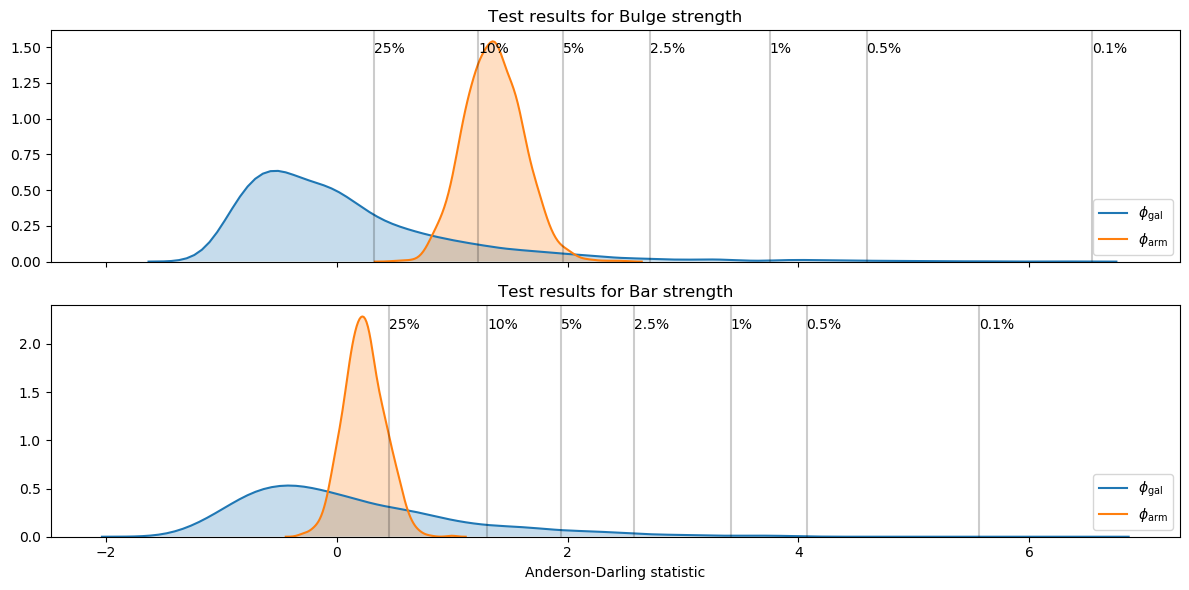

In [62]:
f, ax = plt.subplots(nrows=2, figsize=(12, 6), sharex=True, dpi=100)
plt.sca(ax[0])
plt.title('Test results for Bulge strength')
sns.kdeplot(anderson_bulge['value'], label=r'$\phi_\mathrm{gal}$', shade=True)
sns.kdeplot(arm_anderson_bulge['value'], label=r'$\phi_\mathrm{arm}$', shade=True)
print('Bulge strength Thresholds:')
for i, j in zip(
    ('25%', '10%', '5%', '2.5%', '1%', '0.5%', '0.1%'),
    np.stack(anderson_bulge['levels'].values).mean(axis=0),
):
    freq = (anderson_bulge['value'] >= j).sum() / len(anderson_bulge['value'])
    freq_arm = (arm_anderson_bulge['value'] >= j).sum() / len(arm_anderson_bulge['value'])
    print(f'{i: >10}: {j:.2f}, reject {freq:.0%} ({freq_arm:.0%}) of the time')
    plt.axvline(j, color='k', alpha=0.2)
    plt.text(j, plt.ylim()[1]*0.9, i)
plt.legend(loc='lower right')
plt.sca(ax[1])
plt.title('Test results for Bar strength')
sns.kdeplot(anderson_bar['value'], label=r'$\phi_\mathrm{gal}$', shade=True)
sns.kdeplot(arm_anderson_bar['value'], label=r'$\phi_\mathrm{arm}$', shade=True)
print('Bar strength Thresholds:')
for i, j in zip(
    ('25%', '10%', '5%', '2.5%', '1%', '0.5%', '0.1%'),
    np.stack(anderson_bar['levels'].values).mean(axis=0)
):
    freq = (anderson_bar['value'] >= j).sum() / len(anderson_bar['value'])
    freq_arm = (arm_anderson_bar['value'] >= j).sum() / len(arm_anderson_bar['value'])
    print(f'{i: >10}: {j:.2f}, reject {freq:.0%} ({freq_arm:.0%}) of the time')
    plt.axvline(j, color='k', alpha=0.2)
    plt.text(j, plt.ylim()[1]*0.9, i)
plt.xlabel('Anderson-Darling statistic')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('plots/bulge_bar_test_results.pdf', bbox_inches='tight')
plt.savefig('plots/bulge_bar_test_results.jpg', bbox_inches='tight')

These samples are even less likely to be drawn from different distributions! Interestingly, it's interesting that arms seem to be more consistent than galaxies. This could simply be an artefact of the data / method.

So, to answer our question: we do not see evidence for a correlation between pitch angle and bulge or bar strength, and there is insufficient evidence to conclude that there is any difference between the pitch angle distributions of unbarred vs strongly barred galaxies or disc-dominated vs obvious-bulge galaxies.

(even when using $E[\phi]$)

In [63]:
phi_gal_est = gal_pa_samples.reindex(morphology_comparison.index).mean(axis=1)
print('For gal pa')
print(st.anderson_ksamp((
    # no bar
    phi_gal_est[morphology_comparison['no_bar']],
    # weak bar
    phi_gal_est[~(
        morphology_comparison['no_bar'].astype(bool)
        | morphology_comparison['strongly_barred'].astype(bool)
    )],
    # strong bar
    phi_gal_est[morphology_comparison['strongly_barred']],
)))
print(st.anderson_ksamp((
    phi_gal_est[morphology_comparison['bulge_dominated']],
    phi_gal_est[~morphology_comparison['bulge_dominated'].astype(bool)]
)))


phi_arm_est = arm_pa_samples_.mean(axis=1)
print('\nFor arm pa')
print(st.anderson_ksamp((
    # no bar
    phi_arm_est[arm_morphology_comparison['no_bar']],
    # weak bar
    phi_arm_est[~(
        arm_morphology_comparison['no_bar'].astype(bool)
        | arm_morphology_comparison['strongly_barred'].astype(bool)
    )],
    # strong bar
    phi_arm_est[arm_morphology_comparison['strongly_barred']],
)))
print(st.anderson_ksamp((
    phi_arm_est[arm_morphology_comparison['bulge_dominated']],
    phi_arm_est[~arm_morphology_comparison['bulge_dominated'].astype(bool)]
)))


For gal pa
Anderson_ksampResult(statistic=0.026444755832029376, critical_values=array([0.44925884, 1.3052767 , 1.9434184 , 2.57696569, 3.41634856,
       4.07210043, 5.56419101]), significance_level=0.25)
Anderson_ksampResult(statistic=0.7059781740107312, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.16855617463100536)

For arm pa
Anderson_ksampResult(statistic=0.25211252203230305, critical_values=array([0.44925884, 1.3052767 , 1.9434184 , 2.57696569, 3.41634856,
       4.07210043, 5.56419101]), significance_level=0.25)
Anderson_ksampResult(statistic=1.425928488231756, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.08387500839858791)
